In [1]:
import laspy as lp
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from optical_group_5.points2dem import dem, classes

In [2]:
#f2 = lp.read("../../data/ALS2018_UP_Golm_06May2018_RGB.laz")
f = lp.read("../../data/2024_Golm_AEO_trees.laz")

In [3]:
ground = lp.read("../../data/Ground Points.las")

## Gen data

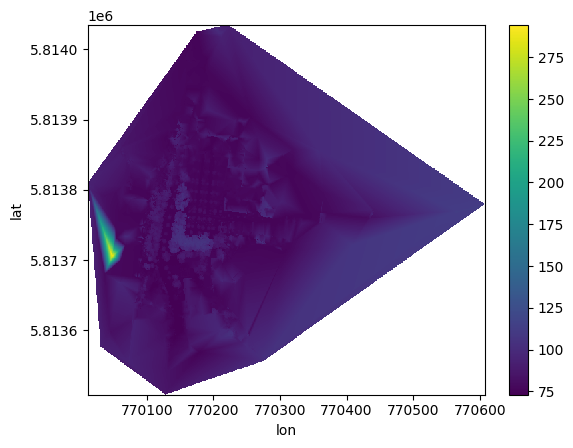

In [4]:
dsm = dem(f, interp=True)
dsm.plot()

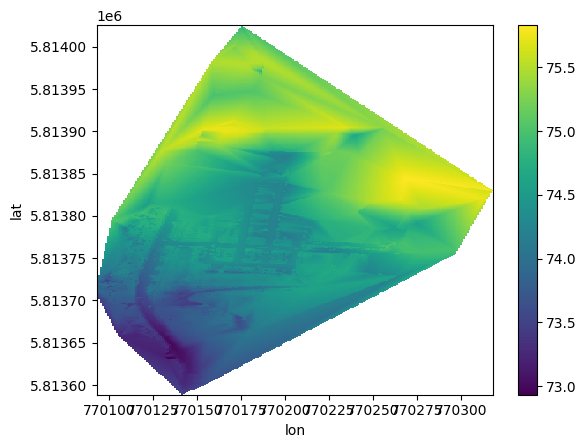

In [11]:
dtm = dem(ground, interp=True)
dtm.plot()

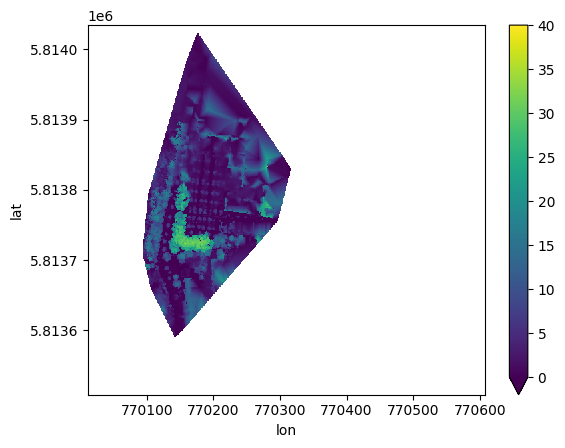

In [6]:
rh = (dsm - dtm.interp_like(dsm))
rh.plot.imshow(vmin=0, vmax=40)

In [13]:
# Align the rasters
dtm = dtm.interp_like(dsm)
rh = rh.interp_like(dsm)

In [14]:
# Add metdata to the rasters
dsm.name = "DSM"
dsm.attrs["units"] = "m"
dsm.attrs["long_name"] = "Digital Surface Model"

dtm.name = "DTM"
dtm.attrs["units"] = "m"
dtm.attrs["long_name"] = "Digital Terrain Model"

rh.name = "Relative_Height"
rh.attrs["units"] = "m"
rh.attrs["long_name"] = "Relative Height"

ds = xr.Dataset(
    {
        "dsm": dsm,
        "dtm": dtm,
        "rh": rh,
    }
)
ds

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 526, lon: 596)
Coordinates:
  * lat      (lat) float64 4kB 5.814e+06 5.814e+06 ... 5.814e+06 5.814e+06
  * lon      (lon) float64 5kB 7.7e+05 7.7e+05 7.7e+05 ... 7.706e+05 7.706e+05
Data variables:
    dsm      (lat, lon) float64 3MB nan nan nan nan nan ... nan nan nan nan nan
    dtm      (lat, lon) float64 3MB nan nan nan nan nan ... nan nan nan nan nan
    rh       (lat, lon) float64 3MB nan nan nan nan nan ... nan nan nan nan nan

In [15]:
import ipywidgets as widgets
from ipywidgets import interactive
import numpy as np
import matplotlib.pyplot as plt

def plot_rh(min_height = 0, max_height = 40):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a masked array where values outside the range are masked
    rh_masked = np.ma.masked_outside(rh, min_height, max_height)
    
    # Plot the masked array with the origin at the lower left corner
    ax.imshow(rh_masked, vmin=min_height, vmax=max_height, cmap='seismic', origin='lower')
    plt.show()

interactive_plot = interactive(plot_rh, min_height=(-1, 40, 0.1), max_height=(0, 40, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='min_height', max=40.0, min=-1.0), FloatSlider(value=…